# Small-Scale Unit Prediction

The parcel data we are working with is quite large, and therefore takes a very long time to load into notebooks. In order to more easily figure out our pipeline (without having to wait for it to load in each time), we will load only Los Angeles County, as it contains the arbitrary bbox we have chosen for our small-scale analysis.

The following notebook contains the following analysis:
1. Load in parcel, Zillow, and building footprint data.


**Account for missing, multi-family building data**

2. Select only Zillow observations that are categorized as multi-family homes.

3. Spatial join between parcel and multi-family Zillow data. Result: only residential parcels for multi-family homes.

4. Spatial join between residential parcels and building footprints. Result: only residential, multi-family home footprints.

**Predicting unit data**

5. Calculate building volume from footprint area and height.

6. Remove outliers based on residual size.

7. Select only observations that have unit data.

8. Regress building volume on number of housing units to determine relationship.

9. Use linear relationship to predict missing unit data.

**Address single family homes**

10. Spatial join between Zillow and single-family data, calculate volume.

**Final merge**

11. Concatenate complete multi-family data with residential single-family data.

## Load in Data

In [ ]:
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

In [3]:
# import necessary libraries
import pandas as pd
from shapely.geometry import box
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import zipfile
import fiona
from sklearn.linear_model import LinearRegression

In [53]:
# set option to see all data frame columns
pd.set_option('display.max_columns', None)

### Parcel

Los Angeles parquet file: w120_n35_w115_n30.parquet

Access: 

In [4]:
# view layers within .gdb file
fiona.listlayers("data/Parcels_CA_2014.gdb")

['CA_PARCELS_STATEWIDE_INFO', 'CA_PARCELS_STATEWIDE']

In [5]:
# load parcels only for Los Angeles county (will take about 5 minutes)
parcels = gpd.read_file(
    "data/Parcels_CA_2014.gdb",
    layer="CA_PARCELS_STATEWIDE",
    where="County='Los Angeles'").to_crs(epsg=4326)

<Axes: >

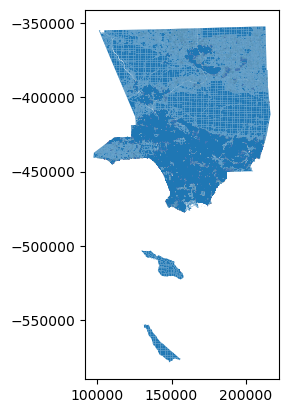

In [6]:
# check that data was loaded properly by plotting
parcels.plot()

### Zillow 

Point data containing variables such as 

In [8]:
# import Zillow data (make take 10-20 minutes)
fp = os.path.join('data', 'final_zillow.gpkg')
zillow = gpd.read_file(fp).to_crs(epsg=4326)

### Building Footprint

There are a total of 8 parquet files that correspond to California. We select the one that contain Los Angeles county.

Access:

In [11]:
# import building footprint as geopandas dataframe (may take 1-5 minutes)
fp = os.path.join('data', 'building_parquets', 'w120_n35_w115_n30.parquet')
building = gpd.read_parquet(fp).to_crs(epsg=4326)

## Account for Missing Multi-Family Data

A simple join between Zillow points and building footprints resulted in missing data, particularly with observations that were identified as multi-family. This is because multi-family housing complexes are often dispersed/made up of multiple buildings, meaning the Zillow points don't always match up to the footprint polygons.

Introducing parcel data solves this issue as it is a larger area, and guarantees that the Zillow point will be in the appropriate parcel. 

In [12]:
# familiarize ourselves with data
zillow.head(3)

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
0,Multi,2003.0,1.0,None,None,I,224.0,491943.0,living,1003.0,3,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
1,Multi,2003.0,1.0,None,None,None,224.0,240117.0,living,936.0,4,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
2,Multi,2003.0,1.0,None,None,I,224.0,261770.0,living,997.0,5,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
3,Multi,2003.0,1.0,None,None,None,224.0,223337.0,living,1002.0,6,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
4,Multi,2003.0,1.0,None,None,None,224.0,241347.0,living,1003.0,7,06001403302,468,PGE/SCE,RR106,POINT (-122.26798 37.79406)


In [15]:
# select only multi-family data
zillow_multi = zillow[zillow['type'] == "Multi"]

zillow_multi.head(3)

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
0,Multi,2003.0,1.0,None,None,I,224.0,491943.0,living,1003.0,3,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
1,Multi,2003.0,1.0,None,None,None,224.0,240117.0,living,936.0,4,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
2,Multi,2003.0,1.0,None,None,I,224.0,261770.0,living,997.0,5,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)


In [16]:
# crop to residential parcels (by keeping those with Zillow points within)
valid_parcels = parcels.sjoin(zillow_multi, predicate="contains").index.unique()
parcels_res = parcels.loc[valid_parcels]

In [17]:
# confirm that joining with Zillow decreased the number of parcels
print(f"Original parcel rows: {len(parcels)}")
print(f"Residential parcel rows: {len(parcels_res)}")
print(f"There are less residential parcels than total parcels: {len(parcels_res) < len(parcels)}")

Original parcel rows: 2389138
Residential parcel rows: 551175
There are less residential parcels than total parcels: True


In [18]:
# crop to residential buildings (by keeping only those within residential parcels)
valid_buildings = building.sjoin(parcels_res, predicate="intersects").index.unique()
buildings_res = building.loc[valid_buildings]

In [19]:
# confirm that joining with Zillow decreased the number of parcels
print(f"Original building rows: {len(building)}")
print(f"Residential building rows: {len(buildings_res)}")
print(f"There are less residential buildings than total total: {len(buildings_res) < len(building)}")

Original building rows: 9503685
Residential building rows: 675547
There are less residential buildings than total total: True


In [20]:
# keep all residential buildings, and add zillow points only where they match up
building_zillow = gpd.sjoin(
    buildings_res,
    zillow_multi,
    how = "left",
    predicate = "intersects")

In [23]:
# confirm that at least some buildings have Zillow data
building_zillow[~building_zillow['unit'].isna()].head(3)

,source,id,height,var,region,bbox,geometry,index_right,type,year,...,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code
1199394,osm,470435154,4.898030,0.318184,USA,"{'xmin': -117.7049224, 'ymin': 34.095399400000...","POLYGON ((-117.70479 34.09554, -117.70481 34.0...",2747575.0,Multi,NaN,...,None,2.0,292666.0,living,2129.0,4033224.0,06037401901,1327,PGE/SCE,RI101
1199414,osm,470435140,3.046337,0.290904,USA,"{'xmin': -117.7049412, 'ymin': 34.0958166, 'xm...","POLYGON ((-117.70484 34.09582, -117.70486 34.0...",2532297.0,Multi,NaN,...,None,2.0,45408.0,living,1456.0,3787338.0,06037401901,1327,PGE/SCE,RI101
1199416,osm,470435136,6.251768,0.752298,USA,"{'xmin': -117.704726, 'ymin': 34.0958261, 'xma...","POLYGON ((-117.70468 34.09601, -117.70465 34.0...",2747574.0,Multi,NaN,...,None,2.0,475673.0,living,2088.0,4033223.0,06037401901,1327,PGE/SCE,RI101


### Predicing Unit Data

#### Find building volume

In [24]:
# reproject data frame to crs with meters as units
building_m = building_zillow.to_crs("EPSG:6933")

In [25]:
# create column from polygon area
building_m['area_m2'] = building_m.geometry.area

# rename height column to be clear about units
building_m.rename(columns={"height":"height_m"}, inplace = True)

building_m.head(2)

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,...,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2
1199366,osm,470435170,4.024961,0.620044,USA,"{'xmin': -117.7061048, 'ymin': 34.095258499999...","POLYGON ((-11357024.215 4103208.262, -11357015...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.958599
1199367,osm,470435165,4.172357,0.215071,USA,"{'xmin': -117.70619690000001, 'ymin': 34.09533...","POLYGON ((-11357025.797 4103205.345, -11357032...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.752743


In [26]:
# create volume column
building_m['volume_m3'] = building_m['area_m2'] * building_m['height_m']

building_m.head(2)

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,...,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2,volume_m3
1199366,osm,470435170,4.024961,0.620044,USA,"{'xmin': -117.7061048, 'ymin': 34.095258499999...","POLYGON ((-11357024.215 4103208.262, -11357015...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.958599,398.304455
1199367,osm,470435165,4.172357,0.215071,USA,"{'xmin': -117.70619690000001, 'ymin': 34.09533...","POLYGON ((-11357025.797 4103205.345, -11357032...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.752743,228.447967


In [27]:
# explore number of rows that don't have unit data -- it's a lot
building_m['unit'].isna().sum()

497532

In [28]:
# keep only observations with unit data
building_w_units = building_m[~building_m['unit'].isna()]

# confirm operation worked
building_w_units['unit'].isna().sum()

0

<Axes: xlabel='volume_m3', ylabel='unit'>

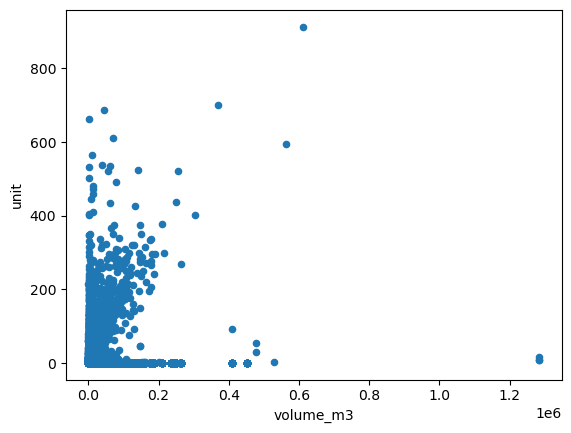

In [29]:
# plot units vs volume^3
building_w_units.plot(kind='scatter',
              x='volume_m3', 
              y='unit')

#### Remove outliers based on residual size 

In [34]:
# reshape data to (n_samples, 1) 

# x-values
volume = np.array(building_w_units['volume_m3']).reshape((-1,1))
print(f"Input data shape: {x.shape}")

# y-values
unit = np.array(building_w_units['unit'])
print(f"Output data shape: {y.shape}")

Input data shape: (335726, 1)
Output data shape: (335726,)


In [35]:
# fit model
model = LinearRegression().fit(volume, unit)

In [36]:
## extract residuals 
# run model on every value of volume to get predicted units
predicted = model.predict(volume)
# calculate residuals
residuals = unit - predicted

# standardize them (makes filter more interpretable)
std_residuals = (residuals - residuals.mean()) / residuals.std()

In [41]:
# keep only points within threshold
mask = np.abs(std_residuals) < 2.5
volume_clean = volume[mask]
unit_clean = unit[mask]

# clean dataframe --> not technically necessary for model
building_w_units_clean = building_w_units[mask]

In [43]:
# fit new model
model = LinearRegression().fit(volume_clean, unit_clean)

<Axes: xlabel='volume_m3', ylabel='unit'>

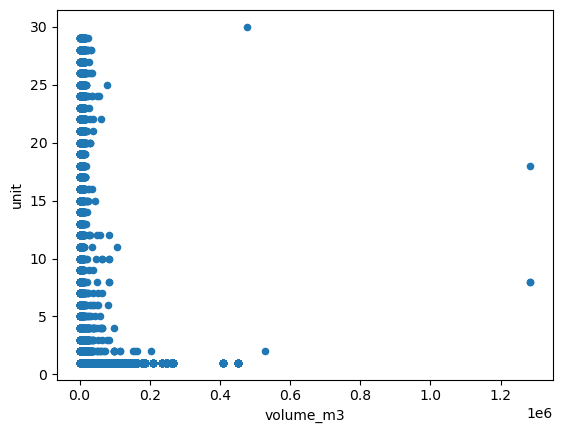

In [44]:
# plot units vs volume^3
building_w_units_clean.plot(kind='scatter',
              x='volume_m3', 
              y='unit')

Input data shape: (299664, 1)
Output data shape: (299664,)


In [48]:
R_sq = model.score(x,y)
print(f"Coefficient of determination (R^2): {R_sq}")

# Retrieve intercept and slope
intercept = model.intercept_
print(f"x-axis intercept: {intercept}")

slope = model.coef_[0]
print(f"Slope: {slope}")

Coefficient of determination (R^2): 0.39617029396193637
x-axis intercept: 2.7432152359427975
Slope: 0.0010986369432096897


### Unit Prediction

In [57]:
# keep only multi-unit buildings (they are the only ones with missing data, anyway)
# BETTER TO DO THIS STEP BEFORE
building_multi = building_w_units[building_w_units['type'] == 'Multi']

building_multi.head()

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2,volume_m3,pred_units
1172292,osm,519477027,9.014627,1.452538,USA,"{'xmin': -121.94294729999996, 'ymin': 37.72242...","POLYGON ((-11765821.388 4479656.356, -11765816...",320660.0,Multi,1982.0,3.0,None,None,I,1.0,1119594.0,living,1885.0,365721.0,06001450502,169,PGE/SCE,RI101,232.149874,2092.744628,5.042382
1177921,osm,1107010162,5.895103,1.179340,USA,"{'xmin': -121.87884160000002, 'ymin': 37.73800...","POLYGON ((-11759626.255 4481234.348, -11759621...",382610.0,Multi,2018.0,4.0,None,None,I,2.0,1859606.0,living,4107.0,431626.0,06013355123,179,PGE/SCE,RI101,311.308066,1835.193104,4.759426
1178215,osm,552907644,7.042693,1.734722,USA,"{'xmin': -121.8753766, 'ymin': 37.722328699999...","POLYGON ((-11759301.742 4479656.153, -11759295...",355589.0,Multi,2006.0,4.0,None,None,O,1.0,372393.0,living,1272.0,402426.0,06001450102,179,PGE/SCE,RI110,77.113193,543.084552,3.339868
1178216,osm,552907643,7.042693,1.304207,USA,"{'xmin': -121.87530290000001, 'ymin': 37.72233...","POLYGON ((-11759294.631 4479656.721, -11759288...",355588.0,Multi,2006.0,4.0,None,None,O,1.0,273057.0,living,1272.0,402425.0,06001450102,179,PGE/SCE,RI110,77.941852,548.920543,3.346280
1178217,osm,552907641,6.935098,0.988388,USA,"{'xmin': -121.8751649, 'ymin': 37.722343499999...","POLYGON ((-11759274.524 4479658.546, -11759273...",355586.0,Multi,2006.0,4.0,None,None,O,1.0,397452.0,living,1272.0,402423.0,06001450102,179,PGE/SCE,RI110,83.464693,578.835841,3.379146


In [59]:
building_pred_units = building_multi.copy()

# Predict number of units for data without unit data using regression formula
building_pred_units['pred_units'] = building_multi['volume_m3'] * slope + intercept

In [60]:
building_pred_units.head()

,source,id,height_m,var,region,bbox,geometry,index_right,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,area_m2,volume_m3,pred_units
1172292,osm,519477027,9.014627,1.452538,USA,"{'xmin': -121.94294729999996, 'ymin': 37.72242...","POLYGON ((-11765821.388 4479656.356, -11765816...",320660.0,Multi,1982.0,3.0,None,None,I,1.0,1119594.0,living,1885.0,365721.0,06001450502,169,PGE/SCE,RI101,232.149874,2092.744628,5.042382
1177921,osm,1107010162,5.895103,1.179340,USA,"{'xmin': -121.87884160000002, 'ymin': 37.73800...","POLYGON ((-11759626.255 4481234.348, -11759621...",382610.0,Multi,2018.0,4.0,None,None,I,2.0,1859606.0,living,4107.0,431626.0,06013355123,179,PGE/SCE,RI101,311.308066,1835.193104,4.759426
1178215,osm,552907644,7.042693,1.734722,USA,"{'xmin': -121.8753766, 'ymin': 37.722328699999...","POLYGON ((-11759301.742 4479656.153, -11759295...",355589.0,Multi,2006.0,4.0,None,None,O,1.0,372393.0,living,1272.0,402426.0,06001450102,179,PGE/SCE,RI110,77.113193,543.084552,3.339868
1178216,osm,552907643,7.042693,1.304207,USA,"{'xmin': -121.87530290000001, 'ymin': 37.72233...","POLYGON ((-11759294.631 4479656.721, -11759288...",355588.0,Multi,2006.0,4.0,None,None,O,1.0,273057.0,living,1272.0,402425.0,06001450102,179,PGE/SCE,RI110,77.941852,548.920543,3.346280
1178217,osm,552907641,6.935098,0.988388,USA,"{'xmin': -121.8751649, 'ymin': 37.722343499999...","POLYGON ((-11759274.524 4479658.546, -11759273...",355586.0,Multi,2006.0,4.0,None,None,O,1.0,397452.0,living,1272.0,402423.0,06001450102,179,PGE/SCE,RI110,83.464693,578.835841,3.379146


### Plot with points and regression line

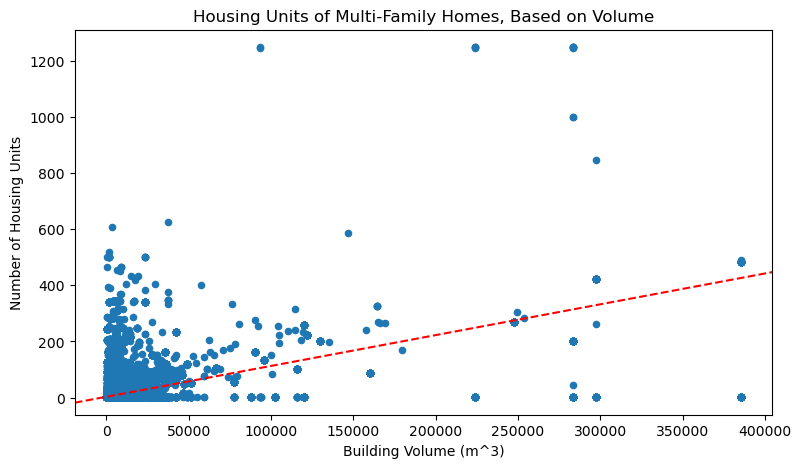

In [65]:
# preliminary plot (alameda county only)

# initialize plot
fig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 1)

# plot building polygons
building_w_units.plot(ax =ax,
                      kind='scatter',
                      x='volume_m3', 
                      y='unit')

# plot zillow points
ax.axline(xy1=(0, intercept), slope=slope, color='r', linestyle='--', label=f'y = {slope}x + {intercept}')

plt.title("Housing Units of Multi-Family Homes, Based on Volume")
plt.xlabel("Building Volume (m^3)")
plt.ylabel("Number of Housing Units")
plt.show()